In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def gauss_c(x, m=0, s=1):
    return (1/np.sqrt(2*np.pi*s**2)) * np.exp(-(x-m)**2/(2*s**2))
    
def gauss_d(x, m=0, s=1):
    None

def I(n, t):
    
    np.factorial(m)
    
def gamma(n):
    return np.factorial(n-1)
    
    

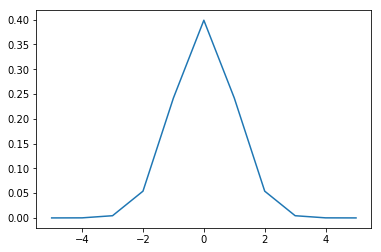

In [3]:
x = np.arange(11)-5

plt.plot(x, gauss_c(x))
plt.show()

In [58]:
from astropy.io import fits
import os
import sep

from scipy.stats import multivariate_normal

In [6]:
def make_nonnegative(img):
    epsilon = np.abs(img.min()) + 1e-3
    img[img<=0] = img[img>0].min()
    return img

def get_random_spheroids(num=10):
    with open('../spheroids', 'r') as f:
        spheroids = np.array(f.readlines())
    
    if num==-1:
        num = len(spheroids)
    
    selected = np.random.choice(spheroids, num, replace=False)
    
    data_dir = os.path.join(os.getenv('HOME'), 'Documents/astro_data/orig_images')
    fmask = 'GDS_{}_{}.fits'
    f_string = os.path.join(data_dir, fmask)

    sources = []
    for s in selected:
        img = fits.getdata(f_string.format(s.strip(), 'h'))
        segmap = fits.getdata(f_string.format(s.strip(), 'segmap'))
        img_id = int(s.split('_')[1])
        sources.append((img.copy(), segmap.copy(), img_id))
        del img 
        del segmap
    
    return sources

def denoise(img, segmap, img_id):
    noise_bank = img[segmap==0].flatten()
    other_source = np.logical_and(segmap!=0, segmap!=img_id)
    np.place(img, other_source, noise_bank)
    
    array_sep_likes = img.byteswap().newbyteorder()
    bkg = sep.Background(array_sep_likes, mask=segmap==img_id, bw=10, bh=10)
    img = img-bkg
    
    return img

In [94]:
source = get_random_spheroids(1)

[20.619796999942174, 21.126083764455057]
[[ 0.00105216  0.00105543]
 [ 0.00105543  0.00107617]]


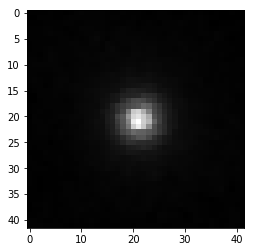

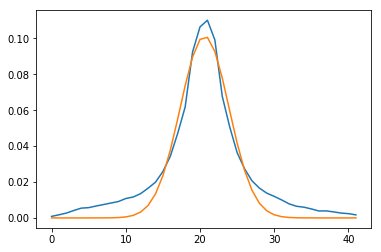

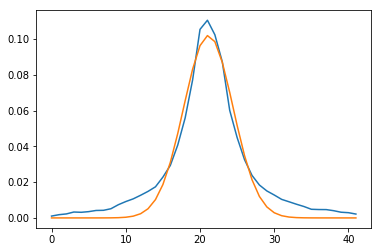

In [100]:
img, segmap, img_id = source[0]
img = denoise(img, segmap, img_id)[21:63, 21:63]
#img[segmap!=img_id] = 0

#img += np.abs(img.min())
#img /= img.sum()

plt.imshow(img, cmap='gray')

ys, xs = np.zeros(img.shape[0]), np.zeros(img.shape[1])
for y in range(img.shape[0]):
    for x in range(img.shape[1]):
        ys[y] += img[y,x]
        xs[x] += img[y,x]

ys /= ys.sum()
xs /= xs.sum()

def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

def fit_gauss(vals):
    xs = np.arange(vals.shape[0])
    mu = np.mean(vals*xs)
    sigma = np.mean(vals * (xs-mu)**2)

    popt,pcov = curve_fit(gaus,np.arange(vals.shape[0]),vals,p0=[1,mu,sigma])
    return popt
    
y_scale, y_mean, y_sigma = fit_gauss(ys)
y_fit = gaus(np.arange(img.shape[0]),y_scale, y_mean, y_sigma)

plt.figure()
plt.plot(ys)
plt.plot(y_fit)



x_scale, x_mean, x_sigma = fit_gauss(xs)
x_fit = gaus(np.arange(img.shape[0]),x_scale, x_mean, x_sigma)

plt.figure()
plt.plot(xs)
plt.plot(x_fit)

cov = np.cov(y_fit, x_fit)
mu = [y_mean, x_mean]

print(mu)
print(cov)

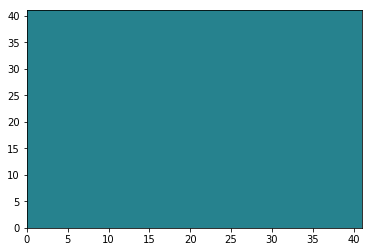

In [101]:
X = np.arange(img.shape[0])
Y = X.T
Y, X = np.meshgrid(Y, X)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

Z = multivariate_normal(mu, cov)
Z = Z.pdf(pos)

plt.contourf(X, Y, Z)


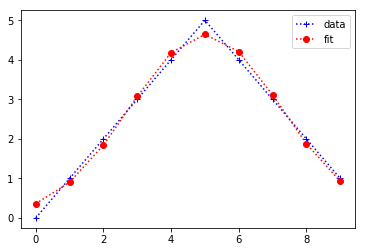

In [29]:

from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

x = ar(range(10))
y = ar([0,1,2,3,4,5,4,3,2,1])

n = len(x)                          #the number of data
mean = sum(x*y)/n                   #note this correction
sigma = sum(y*(x-mean)**2)/n        #note this correction



popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

plt.plot(x,y,'b+:',label='data')
plt.plot(x,gaus(x,*popt),'ro:',label='fit')
plt.legend()